In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from PMTgiom import PMTs
from scipy.interpolate import interp1d
# sns.set(style="whitegrid")
# pd.set_option('display.width', None)          # No line wrapping
# pd.set_option('display.max_columns', None)    # Show all columns
# pd.set_option('display.max_colwidth', None)
energy=np.array([10,20,30,40,36,70,60,100,200,300,800,1000,2000,10000,9,5,3,2,50]) # keV
ph_per_kev=np.array([65.8,68.1,67.2,67.2,66.9,66.7,67,64.5,62.2,60.7,59.6,59.1,58.2,57.1,64.8,60.8,55.9,50,67.2])

photons_per_keV = interp1d(np.sort(energy), ph_per_kev[np.argsort(energy)], kind='linear', fill_value="extrapolate")  

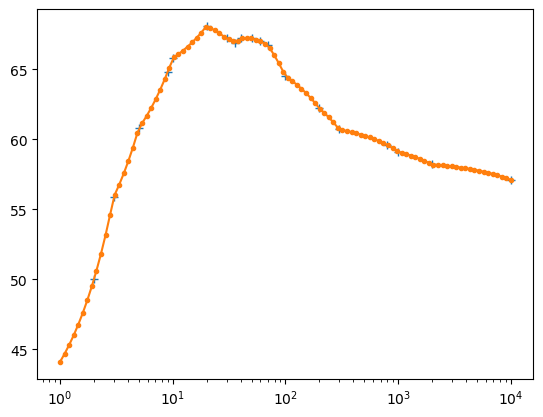

In [22]:
x=10**(np.linspace(0,4,100))
plt.figure()
plt.plot(energy, ph_per_kev, '+')
plt.plot(x, photons_per_keV(x), '.-')
plt.xscale('log')
plt.show()

In [24]:
def make_clusters(df):
    coordinates = df[['x', 'y', 'z']].values
    clustering = DBSCAN(eps=1e-5, min_samples=1).fit(coordinates)
    df['cluster_id'] = clustering.labels_
    cluster_centers = df.groupby('cluster_id')[['x', 'y', 'z']].mean().rename(columns={
        'x': 'center_x', 'y': 'center_y', 'z': 'center_z'}).reset_index()
    df = df.merge(cluster_centers, on='cluster_id', suffixes=('', '_center'))
    df['distance_to_center'] = np.sqrt(
        (df['x'] - df['center_x'])**2 +
        (df['y'] - df['center_y'])**2 +
        (df['z'] - df['center_z'])**2
    )
    df_filtered = df[df['distance_to_center'] <= 5e-3]
    return df_filtered

In [33]:
df.to_pickle('Co60_step_240225A.pkl')

In [26]:
pdg_dict = {
    22: 'gamma',    # Photon
    11: 'e-',       # Electron
    -11: 'e+'       # Positron
}
df = pd.concat([pd.read_csv(f'build/output_nt_HitData_t{i}.csv', skiprows=14, header=None, names=['eventID', 'pdg', 'particle in', 'interaction type', 'edep', 'x', 'y', 'z', 't']) for i in range(8)])
df['r']=np.sqrt(df['x']**2+df['y']**2+df['z']**2)
df['particle'] = df['pdg'].map(pdg_dict).fillna('other')
df = df[df['interaction type'] != 'Transportation']
df = df[df['interaction type'] != 'Rayl']
df['medium'] = np.where(df['r'] <= 10, 'LXe', np.where(df['r'] < 30, 'HPFS', 'Air'))
df['edep']=df['edep']*1000

In [30]:
row=[]
for i, (ev, grp) in enumerate(df.groupby(['eventID'])):
    tag=''
    if not 'LXe' in grp['medium'].unique(): continue
    if (grp[grp['medium']=='LXe']['particle in']!='gamma').all(): 
        tag='msc without a source'
    grp=grp.sort_values('t')
    # sub=grp[grp['medium']=='LXe']
    # sub=make_clusters(sub)
    # energy_list=[grp['edep'].sum() for i,grp in sub.groupby(['cluster_id'])]
    # cluster_x=[grp['center_x'].iloc[0] for i,grp in sub.groupby(['cluster_id'])]
    # cluster_y=[grp['center_y'].iloc[0] for i,grp in sub.groupby(['cluster_id'])]
    # cluster_z=[grp['center_z'].iloc[0] for i,grp in sub.groupby(['cluster_id'])]
    # row.append({'eventID': ev, 'duration': sub['t'].max()-sub['t'].mean(), 'energy list': energy_list, 'cluster_x': cluster_x, 'cluster_y': cluster_y,
    #             'cluster_z': cluster_z, 'number of clusters': len(energy_list), 'tag': tag})
    row.append({'eventID': ev, 'duration': grp['t'].max()-grp['t'].mean(), 'edep': grp['edep'].sum(), 'number of photons':
                np.random.poisson(grp['edep'].sum()*photons_per_keV(grp['edep'].sum())), 'tag': tag})
gf=pd.DataFrame(row)

In [34]:
gf.to_pickle('Co60_ev_240225A.pkl')

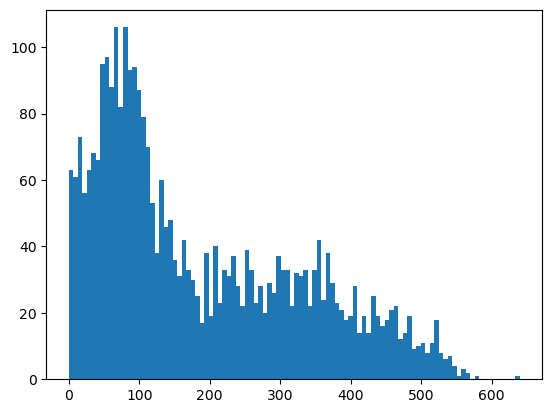

In [32]:
plt.figure()
plt.hist(np.random.binomial(gf['number of photons'], 21**2/40**2/(4*np.pi)*0.3), bins=100)
plt.show()

In [32]:
R=[]
for ev, GRP in gf.groupby(['eventID']):
    grp=GRP.iloc[0]
    if len(grp['energy list'])==1: continue
    for i in range(len(grp['energy list'])-1):
        for j in range(i+1, len(grp['energy list'])):
            r=np.sqrt((grp['cluster_x'][j]-grp['cluster_x'][i])**2+(grp['cluster_y'][j]-grp['cluster_y'][i])**2+
                             (grp['cluster_z'][j]-grp['cluster_z'][i])**2)
            R.append(r)

eventID                                         (4297,)
duration                                       0.016826
energy list           [0.0, 736.1339999999999, 78.2236]
cluster_x                 [0.856129, 0.992947, 1.02462]
cluster_y                [-5.02229, -5.82489, -5.77558]
cluster_z                 [8.60486, -6.00094, -6.22637]
number of clusters                                    3
tag                                                    
Name: 8, dtype: object
eventID                                         (4297,)
duration                                       0.016826
energy list           [0.0, 736.1339999999999, 78.2236]
cluster_x                 [0.856129, 0.992947, 1.02462]
cluster_y                [-5.02229, -5.82489, -5.77558]
cluster_z                 [8.60486, -6.00094, -6.22637]
number of clusters                                    3
tag                                                    
Name: 8, dtype: object
eventID                                 (5419,)
duration  

In [42]:
%matplotlib qt
plt.figure()
plt.hist(R, bins=np.linspace(0,1e-1,100))
plt.yscale('log')
plt.show()

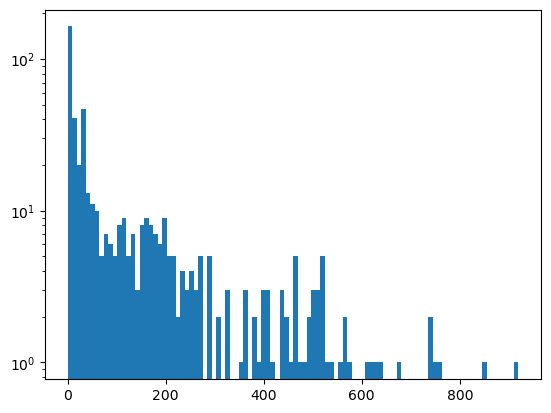

In [25]:
def draw_photons(row):
    